In [5]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/bennyfish/anaconda3/envs/PythonData/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# load dataset
df = read_csv('data/clean_data.csv', header=0, index_col=0)
dataset = df.loc[:,['Life_Expectancy','Adult_Mortality','BMI','Year']]
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())
# print(values[:10])
# split into train and test sets
# from sklearn.model_selection import train_test_split
# values = reframed.values
# print(values[:10])
# y = dataset['Life_Expectancy']
# print(y.count())
# train_X, test_X, train_y, test_y = train_test_split(values, y, random_state=42)

values = reframed.values
n_train_hours = int(len(dataset['Year'])*.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.544592   0.362881   0.236292   1.000000  0.447818
2   0.447818   0.373961   0.229765   0.933333  0.447818
3   0.447818   0.369806   0.223238   0.866667  0.440228
4   0.440228   0.375346   0.216710   0.800000  0.434535
5   0.434535   0.379501   0.211488   0.733333  0.426945
(2316, 1, 4) (2316,) (579, 1, 4) (579,)


Train on 2316 samples, validate on 579 samples
Epoch 1/50
 - 2s - loss: 0.4926 - val_loss: 0.3304
Epoch 2/50
 - 0s - loss: 0.2011 - val_loss: 0.1162
Epoch 3/50
 - 0s - loss: 0.1102 - val_loss: 0.1066
Epoch 4/50
 - 0s - loss: 0.0977 - val_loss: 0.0970
Epoch 5/50
 - 0s - loss: 0.0885 - val_loss: 0.0876
Epoch 6/50
 - 0s - loss: 0.0804 - val_loss: 0.0791
Epoch 7/50
 - 0s - loss: 0.0730 - val_loss: 0.0723
Epoch 8/50
 - 0s - loss: 0.0664 - val_loss: 0.0662
Epoch 9/50
 - 0s - loss: 0.0607 - val_loss: 0.0606
Epoch 10/50
 - 0s - loss: 0.0556 - val_loss: 0.0556
Epoch 11/50
 - 0s - loss: 0.0512 - val_loss: 0.0498
Epoch 12/50
 - 0s - loss: 0.0471 - val_loss: 0.0466
Epoch 13/50
 - 0s - loss: 0.0441 - val_loss: 0.0437
Epoch 14/50
 - 0s - loss: 0.0419 - val_loss: 0.0417
Epoch 15/50
 - 0s - loss: 0.0402 - val_loss: 0.0419
Epoch 16/50
 - 0s - loss: 0.0397 - val_loss: 0.0405
Epoch 17/50
 - 0s - loss: 0.0386 - val_loss: 0.0398
Epoch 18/50
 - 0s - loss: 0.0376 - val_loss: 0.0406
Epoch 19/50
 - 0s - loss: 

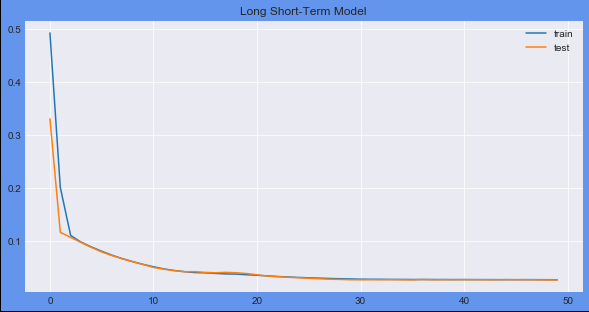

Test MSE: 13.126
Test RMSE: 3.623


In [8]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
sns.set_style('darkgrid')
fig = pyplot.figure(figsize=(10,5), edgecolor='black', facecolor='cornflowerblue',linewidth=1.5)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Long Short-Term Model')
pyplot.legend()
pyplot.savefig('images/LSTM.png',facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
rmse = sqrt(mse)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)